In [1]:

import os 
import random 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle


from PIL import Image


In [2]:

import torch 
import torch.nn as nn 
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

import torchvision
from torchsummary import summary

from sklearn.model_selection import train_test_split


In [3]:

print(torch.cuda.device_count())
device = "cuda" if torch.cuda.is_available() else "cpu"
device


0


/home/yasin/all_program/self_driving_car/venv/lib/python3.13/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

<br>
<br>


# `#01: Data Preparation: `

<br>
<br>

In [4]:

random.seed(42)
torch_seed = torch.manual_seed(42)


In [5]:


# load all the collected images:
df1 = pd.read_csv("data1/log_0.csv", names=["path", "angle"], header=None)
df2 = pd.read_csv("data1/log_1.csv", names=["path", "angle"], header=None)
df3 = pd.read_csv("data1/log_2.csv", names=["path", "angle"], header=None)
df4 = pd.read_csv("data1/log_3.csv", names=["path", "angle"], header=None)
print(f"{len(df1)} --- {len(df2)} ---  {len(df3)} --- {len(df4)}")
print(f"Total collected image: {len(df1) + len(df2) + len(df3) + len(df4)}")



126 --- 410 ---  1056 --- 1024
Total collected image: 2616


In [6]:

df = pd.concat((df1,df2,df3,df4),axis=0)
df.head(5), len(df)

(                                                path  angle
 0  /home/yasin/Desktop/car/data/IMG0/Image_176469...    0.0
 1  /home/yasin/Desktop/car/data/IMG0/Image_176469...    0.0
 2  /home/yasin/Desktop/car/data/IMG0/Image_176469...    0.0
 3  /home/yasin/Desktop/car/data/IMG0/Image_176469...    0.0
 4  /home/yasin/Desktop/car/data/IMG0/Image_176469...    0.0,
 2616)

<Axes: xlabel='angle'>

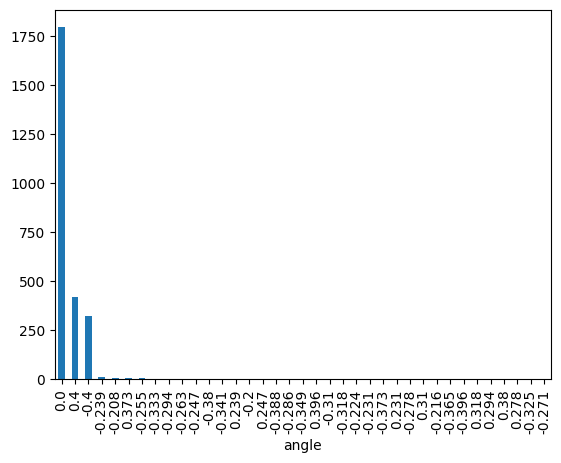

In [7]:

df["angle"].value_counts().plot(kind='bar')


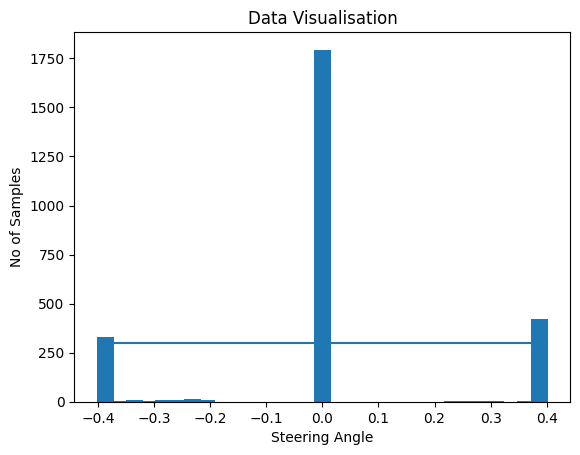

In [8]:

nBin = 31
samplesPerBin =  300
hist, bins = np.histogram(df['angle'], nBin)
if display:
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.03)
    plt.plot((np.min(df['angle']), np.max(df['angle'])), (samplesPerBin, samplesPerBin))
    plt.title('Data Visualisation')
    plt.xlabel('Steering Angle')
    plt.ylabel('No of Samples')
    plt.show()
    

In [9]:


# remove data: 
removeindexList = []
for j in range(nBin):
    binDataList = []
    for i in range(len(df['angle'])):
        if bins[j] <= df['angle'].iloc[i] <= bins[j+1]:
            binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeindexList.extend(binDataList)
    
    

In [10]:


print('Removed Images:', len(removeindexList))
df.drop(df.index[removeindexList], inplace=True)
print('Remaining Images:', len(df))
    

Removed Images: 1647
Remaining Images: 257


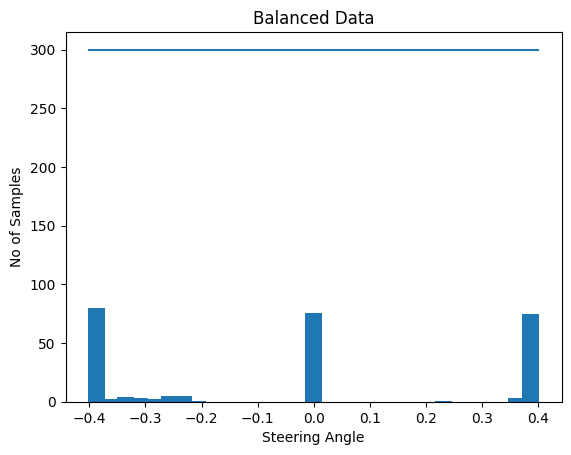

In [11]:


# after removing central: 0.0 image:
hist, _ = np.histogram(df['angle'], (nBin))
plt.bar(center, hist, width=0.03)
plt.plot((np.min(df['angle']), np.max(df['angle'])), (samplesPerBin, samplesPerBin))
plt.title('Balanced Data')
plt.xlabel('Steering Angle')
plt.ylabel('No of Samples')
plt.show()


In [12]:

len(df)


257

In [13]:

df["path"].iloc[0].split("/")[-2:]


['IMG0', 'Image_1764694582735193.jpg']

In [14]:
"/".join(df["path"].iloc[0].split("/")[-2:])

'IMG0/Image_1764694582735193.jpg'

In [15]:
df.sample(5)

,path,angle
825,/home/yasin/Desktop/car/data/IMG3/Image_176469...,0.4
152,/home/yasin/Desktop/car/data/IMG2/Image_176469...,-0.4
848,/home/yasin/Desktop/car/data/IMG3/Image_176469...,-0.4
759,/home/yasin/Desktop/car/data/IMG3/Image_176469...,0.4
393,/home/yasin/Desktop/car/data/IMG1/Image_176469...,-0.4


In [16]:

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)


In [17]:
len(train_df), len(test_df)

(205, 52)

In [18]:

# every time we got different transformed image 
# as the input image is same. No, change to overfitting. This is the magic of Compose function
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((200, 66)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) 
])


# test transformation:
test_transforms = transforms.Compose([
    transforms.Resize((200, 66)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])



In [19]:


class SteeringDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.img_dir + "/" + "/".join(df["path"].iloc[index].split("/")[-2:])
        angle = float(self.df.iloc[index]['angle'])

        
        img = Image.open(img_path).convert("RGB")

        # If transform exists
        if self.transform:
            img = self.transform(img)

        # Handle horizontal fliping the image, need to invert the angle
        if random.random() < 0.5:
            img = transforms.functional.hflip(img)
            angle = -angle

        return img, torch.tensor(angle,dtype=torch.float32)
    

train_data = SteeringDataset(train_df,"data1",transform=train_transforms)
test_data = SteeringDataset(test_df,"data1",transform=test_transforms)

trainLoader = DataLoader(train_data,batch_size=32,shuffle=True)
testLoader = DataLoader(test_data,batch_size=32)

    

In [20]:

# see a batch of data:
data  = iter(trainLoader)
batch_of_data = next(data)
batch_of_data[0][0],batch_of_data[1][0]

(tensor([[[-0.3647, -0.9843, -0.9137,  ..., -0.4980, -0.5059, -0.5216],
          [-0.4118, -0.7647, -0.8275,  ..., -0.4980, -0.5059, -0.5216],
          [-0.4745, -0.4275, -0.7020,  ..., -0.4902, -0.4980, -0.5137],
          ...,
          [-0.0196, -0.0039,  0.0431,  ...,  0.2941,  0.3490,  0.4275],
          [-0.0196, -0.0039,  0.0431,  ...,  0.3020,  0.3412,  0.4039],
          [-0.0196, -0.0039,  0.0431,  ...,  0.3020,  0.3412,  0.3882]],
 
         [[-0.3255, -0.9294, -0.8588,  ..., -0.5294, -0.5373, -0.5608],
          [-0.3412, -0.7020, -0.7725,  ..., -0.5294, -0.5373, -0.5608],
          [-0.3725, -0.3647, -0.6392,  ..., -0.5216, -0.5373, -0.5529],
          ...,
          [-0.0510, -0.0353,  0.0118,  ...,  0.2471,  0.3020,  0.3804],
          [-0.0510, -0.0353,  0.0039,  ...,  0.2549,  0.2941,  0.3647],
          [-0.0510, -0.0353,  0.0039,  ...,  0.2549,  0.2941,  0.3490]],
 
         [[-0.1922, -0.7961, -0.7098,  ..., -0.5686, -0.5765, -0.5922],
          [-0.2078, -0.5843,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].


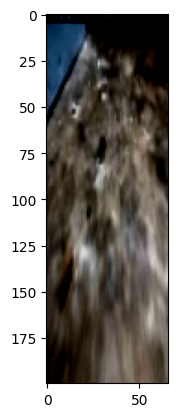

In [21]:
plt.imshow(batch_of_data[0][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


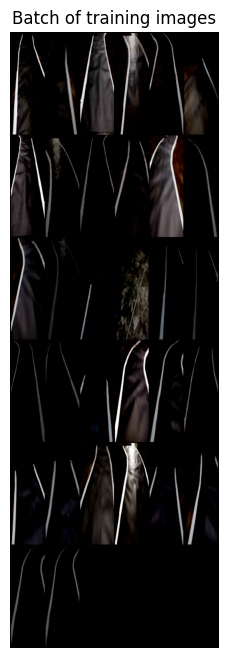

Steering angles: tensor([ 0.4000, -0.2470, -0.0000, -0.4000, -0.4000, -0.4000,  0.0000,  0.0000,
        -0.2550,  0.3490, -0.4000, -0.4000])


In [22]:


# visulize a batch of data
# get one batch
data_iter = iter(trainLoader)
images, angles = next(data_iter)

# make a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=6)  # 6 images per row

# convert to numpy
np_img = img_grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Batch of training images")
plt.show()

# print first few angles from the batch
print("Steering angles:", angles[:12])


<br>
<br>


# `#02: Build the model`

<br>
<br>

In [23]:
dummy = torch.zeros(1, 3, 66, 200)
conv = nn.Sequential(
    nn.Conv2d(3,24,5,2), nn.ELU(),
    nn.Conv2d(24,36,5,2), nn.ELU(),
    nn.Conv2d(36,48,5,2), nn.ELU(),
    nn.Conv2d(48,64,3,1), nn.ELU(),
    nn.Conv2d(64,64,3,1), nn.ELU()
)
out = conv(dummy)
flat_size = out.view(1,-1).size(1)
print(flat_size)


1152


In [24]:



# Pilotnet Architecture:)

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=24,kernel_size=(5,5),stride=(2,2)),
            nn.ELU(),
            nn.Conv2d(in_channels=24,out_channels=36,kernel_size=(5,5),stride=(2,2)),
            nn.ELU(),
            nn.Conv2d(in_channels=36,out_channels=48,kernel_size=(5,5),stride=(2,2)),
            nn.ELU(),
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=(3,3),stride=(1,1)),
            nn.ELU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1)),
            nn.ELU()
        )
        self.flatten_layer = nn.Flatten()
        self.ffn = nn.Sequential(
            nn.Linear(in_features=1152,out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100,out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50,out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10,out_features=1)
        )
    def forward(self,features):
        out = self.convlutional_layer(features)
        #print(out.shape)
        out = self.flatten_layer(out)
        out = self.ffn(out)
        return out 
    
    
model  =  NN()
model


NN(
  (convlutional_layer): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ELU(alpha=1.0)
  )
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (ffn): Sequential(
    (0): Linear(in_features=1152, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [25]:
print(summary(model,input_data=(3,200,66)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 18, 1]           --
|    └─Conv2d: 2-1                       [-1, 24, 98, 31]          1,824
|    └─ELU: 2-2                          [-1, 24, 98, 31]          --
|    └─Conv2d: 2-3                       [-1, 36, 47, 14]          21,636
|    └─ELU: 2-4                          [-1, 36, 47, 14]          --
|    └─Conv2d: 2-5                       [-1, 48, 22, 5]           43,248
|    └─ELU: 2-6                          [-1, 48, 22, 5]           --
|    └─Conv2d: 2-7                       [-1, 64, 20, 3]           27,712
|    └─ELU: 2-8                          [-1, 64, 20, 3]           --
|    └─Conv2d: 2-9                       [-1, 64, 18, 1]           36,928
|    └─ELU: 2-10                         [-1, 64, 18, 1]           --
├─Flatten: 1-2                           [-1, 1152]                --
├─Sequential: 1-3                        [-1, 1]                  

In [26]:


# check with dummy input: 
dummy = torch.randn(1,3,66,200)
output = model(dummy)
print(output.shape)  


torch.Size([1, 1])


In [27]:


# model hyper parameter:
epochs = 100
lr = 0.0005
model = model.to(device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(params=model.parameters(),lr=lr)



for epoch in range(epochs):
    model.train()
    losses = 0
    for img,axis in trainLoader:
        
        img = img.to(device)
        axis = axis.to(device)
        
        # output:
        out = model(img)
        
        # loss: 
        loss = criterion(axis,out)
        losses += loss.item()
        
        #gradient accumulation:
        optim.zero_grad()
        
        #calculate gradient
        loss.backward()
        
        #update:
        optim.step()
    print(f"epoch: {epoch+1}  loss: {losses/len(trainLoader)}")    
    
        

/home/yasin/all_program/self_driving_car/venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/yasin/all_program/self_driving_car/venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1  loss: 0.10855557663100106
epoch: 2  loss: 0.10707837236779076
epoch: 3  loss: 0.10279869022113937
epoch: 4  loss: 0.10390435052769524
epoch: 5  loss: 0.10468920958893639
epoch: 6  loss: 0.10906441722597394
epoch: 7  loss: 0.1082111405474799
epoch: 8  loss: 0.10765819145100457
epoch: 9  loss: 0.10464411335332054
epoch: 10  loss: 0.10244253064904894
epoch: 11  loss: 0.10544421310935702
epoch: 12  loss: 0.10644388518163136
epoch: 13  loss: 0.10909465593951088
epoch: 14  loss: 0.1055757680109569
epoch: 15  loss: 0.10894262152058738
epoch: 16  loss: 0.10807677039078303
epoch: 17  loss: 0.10673341261489051
epoch: 18  loss: 0.10424997551100594
epoch: 19  loss: 0.10574195001806531
epoch: 20  loss: 0.11020095220633916
epoch: 21  loss: 0.10477458153452192
epoch: 22  loss: 0.10548731365374156
epoch: 23  loss: 0.10621602620397295
epoch: 24  loss: 0.10291472396680287
epoch: 25  loss: 0.10577005680118289
epoch: 26  loss: 0.10264338978699275
epoch: 27  loss: 0.10378137124436242
epoch: 28  l

In [28]:
model.eval()
with torch.no_grad():
    val_loss = 0
    for img, axis in testLoader:
        img, axis = img.to(device), axis.to(device)
        out = model(img)
        val_loss += criterion(out, axis).item()
print(f"Validation Loss: {val_loss/len(testLoader):.4f}")


Validation Loss: 0.1049


/home/yasin/all_program/self_driving_car/venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/yasin/all_program/self_driving_car/venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:

torch.save(model.state_dict(), "pilotnet.pth")
